In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import least_squares
import torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from typing import Dict, Tuple, List
import warnings
warnings.filterwarnings('ignore')

# Set up project imports
from import_setup import PROJECT_ROOT

# Now import from our src
from src import (
    Config, load_model_and_tokenizer,
    TemporalDatasetCreator, get_control_words, prepare_control_data,
    extract_all_layer_representations, extract_control_embeddings,
    analyze_all_layers
)

Project root set to: /Users/kadenzheng/manifolds
Python path: ['/Users/kadenzheng/manifolds', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python313.zip', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13']...
✓ src module found and importable


In [2]:
# Create output directories if they don't exist
import os

# Create directories for saving plots and results
os.makedirs('../plots/circle_fitting', exist_ok=True)
os.makedirs('../html', exist_ok=True)
os.makedirs('../notebooks/plots/circle_fitting', exist_ok=True)

print("Output directories created/verified:")
print("  - ../plots/circle_fitting")
print("  - ../html")
print("  - ../notebooks/plots/circle_fitting")


Output directories created/verified:
  - ../plots/circle_fitting
  - ../html
  - ../notebooks/plots/circle_fitting


In [3]:
def fit_circle_2d(points: np.ndarray) -> Tuple[np.ndarray, float, float, float]:
    """
    Fit a circle to 2D points using least squares.
    
    Args:
        points: (n, 2) array of 2D points
        
    Returns:
        tuple: (center, radius, mse, r2)
    """
    def residuals(params, points):
        cx, cy, r = params
        distances = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
        return distances - r
    
    # Initial guess: center at mean, radius as mean distance from center
    center_init = np.mean(points, axis=0)
    radius_init = np.mean(np.linalg.norm(points - center_init, axis=1))
    
    # Optimize
    result = least_squares(
        residuals, 
        [center_init[0], center_init[1], radius_init],
        args=(points,)
    )
    
    cx, cy, r = result.x
    center = np.array([cx, cy])
    
    # Calculate error metrics
    distances = np.linalg.norm(points - center, axis=1)
    mse = mean_squared_error(distances, np.full_like(distances, r))
    
    # Calculate R² - proportion of variance explained by the circle model
    # Correct approach: compare actual positions to predicted positions on the circle
    # Project each point onto the circle
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    predicted_points = np.column_stack([
        center[0] + r * np.cos(angles),
        center[1] + r * np.sin(angles)
    ])
    
    # Calculate residual sum of squares
    ss_res = np.sum((points - predicted_points)**2)
    
    # Calculate total sum of squares (variance from centroid)
    centroid = np.mean(points, axis=0)
    ss_tot = np.sum((points - centroid)**2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return center, r, mse, r2


def fit_circle_nd(points: np.ndarray) -> Tuple[np.ndarray, float, float, float]:
    """
    Fit a hypersphere to n-dimensional points.
    
    Args:
        points: (n_points, n_dims) array
        
    Returns:
        tuple: (center, radius, mse, r2)
    """
    n_points, n_dims = points.shape
    
    def residuals(params, points):
        center = params[:n_dims]
        radius = params[n_dims]
        distances = np.linalg.norm(points - center, axis=1)
        return distances - radius
    
    # Initial guess
    center_init = np.mean(points, axis=0)
    radius_init = np.mean(np.linalg.norm(points - center_init, axis=1))
    
    # Optimize
    result = least_squares(
        residuals,
        np.concatenate([center_init, [radius_init]]),
        args=(points,)
    )
    
    center = result.x[:n_dims]
    radius = result.x[n_dims]
    
    # Calculate error metrics
    distances = np.linalg.norm(points - center, axis=1)
    mse = mean_squared_error(distances, np.full_like(distances, radius))
    
    # Calculate R² for hypersphere using proper position-based approach
    # Project each point onto the hypersphere surface
    directions = points - center
    norms = np.linalg.norm(directions, axis=1, keepdims=True)
    # Handle edge case where point is at center
    unit_directions = np.divide(directions, norms, out=np.zeros_like(directions), where=(norms != 0))
    
    # Predicted points on the hypersphere surface
    predicted_points = center + radius * unit_directions
    
    # Calculate R² using position prediction
    ss_res = np.sum((points - predicted_points)**2)
    centroid = np.mean(points, axis=0)
    ss_tot = np.sum((points - centroid)**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return center, radius, mse, r2


In [4]:
# Initialize configuration
config = Config()
config.batch_size = 32  # Increase batch size for efficiency

# Load model
print("Loading model...")
model, tokenizer = load_model_and_tokenizer(config)
print(f"Model loaded on {config.device}")


Loading model...
Loading model: meta-llama/Llama-3.2-1B
Model loaded on cpu


In [5]:
# Prepare temporal data (add_plur only)
dataset_creator = TemporalDatasetCreator(config)
temporal_data = dataset_creator.create_dataset(contexts=['add_plur'])

# Convert to DataFrame
temporal_df = pd.DataFrame(temporal_data)

# For temporal data, we'll use all the data (no train/test split for circle fitting)
print(f"Temporal dataset size: {len(temporal_df)}")
print(f"Unique days: {temporal_df['day'].nunique()}")
print(f"Offset range: {temporal_df['offset'].min()} - {temporal_df['offset'].max()}")


Temporal dataset size: 413
Unique days: 7
Offset range: 2 - 69


In [6]:
# Prepare control data
control_words = get_control_words()
print(f"Number of control words: {len(control_words)}")
print(f"Sample control words: {control_words[:10]}")


Number of control words: 45
Sample control words: ['apple', 'banana', 'orange', 'grape', 'strawberry', 'carrot', 'broccoli', 'potato', 'tomato', 'lettuce']


In [7]:
# Extract temporal embeddings
print("Extracting temporal embeddings...")
from src.datasets import TemporalDataset

# Tokenize temporal data
temporal_texts = temporal_df['text'].tolist()
temporal_encodings = tokenizer(temporal_texts, truncation=True, padding=True, 
                               return_tensors='pt', max_length=128)

# Create dataset
temporal_dataset = TemporalDataset(temporal_encodings, temporal_df)

# Extract representations from all layers
temporal_layer_reprs, temporal_labels = extract_all_layer_representations(
    model, temporal_dataset, config.device, config.batch_size
)

# IMPORTANT: Use RESULT day labels for coloring (not origin day)
# This means Monday + 3 days = Thursday will be colored as Thursday
result_day_labels = temporal_df['result_day'].values
temporal_labels = result_day_labels  # Override to use result day as primary labels

print(f"Extracted embeddings from {len(temporal_layer_reprs)} layers")
print(f"Using RESULT day labels for all analysis")
print(f"Using RESULT day labels for all analysis")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting temporal embeddings...


Extracting representations: 100%|██████████| 13/13 [00:04<00:00,  2.81it/s]

Extracted embeddings from 17 layers
Using RESULT day labels for all analysis
Using RESULT day labels for all analysis


In [8]:
# Extract control embeddings
print("Extracting control embeddings...")
control_layer_reprs, control_labels = extract_control_embeddings(
    control_words, model, tokenizer, config.device
)

print(f"Control embeddings shape (layer 0): {control_layer_reprs[0].shape}")


Extracting control embeddings...


Extracting representations: 100%|██████████| 2/2 [00:00<00:00,  5.92it/s]

Control embeddings shape (layer 0): (45, 2048)


In [9]:
def fit_circles_pca_space(layer_representations: Dict[int, np.ndarray], 
                         dataset_name: str) -> Dict[int, Dict]:
    """
    Fit circles to data in PCA space for each layer.
    """
    results = {}
    
    for layer_idx, embeddings in layer_representations.items():
        # Apply PCA
        pca = PCA(n_components=2)
        pca_transformed = pca.fit_transform(embeddings)
        
        # Fit circle to 2D PCA projection
        center, radius, mse, r2 = fit_circle_2d(pca_transformed)
        
        results[layer_idx] = {
            'center': center,
            'radius': radius,
            'mse': mse,
            'r2': r2,
            'pca_transformed': pca_transformed,
            'explained_variance': pca.explained_variance_ratio_,
            'dataset': dataset_name
        }
        
    return results


In [10]:
# Fit circles in PCA space for temporal data
print("Fitting circles in PCA space for temporal data...")
temporal_pca_results = fit_circles_pca_space(temporal_layer_reprs, 'temporal')

# Fit circles in PCA space for control data
print("Fitting circles in PCA space for control data...")
control_pca_results = fit_circles_pca_space(control_layer_reprs, 'control')


Fitting circles in PCA space for temporal data...
Fitting circles in PCA space for control data...


In [11]:
def fit_circles_original_space(layer_representations: Dict[int, np.ndarray],
                              dataset_name: str) -> Dict[int, Dict]:
    """
    Fit hyperspheres to data in original embedding space for each layer.
    """
    results = {}
    
    for layer_idx, embeddings in layer_representations.items():
        # Fit hypersphere in original high-dimensional space
        center, radius, mse, r2 = fit_circle_nd(embeddings)
        
        results[layer_idx] = {
            'center': center,
            'radius': radius,
            'mse': mse,
            'r2': r2,
            'n_dims': embeddings.shape[1],
            'dataset': dataset_name
        }
        
    return results


In [12]:
# Fit circles in original space for temporal data
print("Fitting hyperspheres in original space for temporal data...")
temporal_orig_results = fit_circles_original_space(temporal_layer_reprs, 'temporal')

# Fit circles in original space for control data  
print("Fitting hyperspheres in original space for control data...")
control_orig_results = fit_circles_original_space(control_layer_reprs, 'control')


Fitting hyperspheres in original space for temporal data...
Fitting hyperspheres in original space for control data...


In [13]:
# Summarize circle fitting results
def create_summary_df(pca_results: Dict, orig_results: Dict, dataset_name: str) -> pd.DataFrame:
    """
    Create summary DataFrame of circle fitting results.
    """
    rows = []
    
    for layer_idx in pca_results.keys():
        row = {
            'layer': layer_idx,
            'dataset': dataset_name,
            'pca_radius': pca_results[layer_idx]['radius'],
            'pca_mse': pca_results[layer_idx]['mse'],
            'pca_r2': pca_results[layer_idx]['r2'],
            'orig_radius': orig_results[layer_idx]['radius'],
            'orig_mse': orig_results[layer_idx]['mse'],
            'orig_r2': orig_results[layer_idx]['r2'],
            'orig_dims': orig_results[layer_idx]['n_dims']
        }
        rows.append(row)
    
    return pd.DataFrame(rows)

# Create summary DataFrames
temporal_summary = create_summary_df(temporal_pca_results, temporal_orig_results, 'temporal')
control_summary = create_summary_df(control_pca_results, control_orig_results, 'control')

# Combine summaries
all_results = pd.concat([temporal_summary, control_summary])


In [14]:
# Display results for temporal data
print("\nTemporal Data Circle Fitting Results:")
print("="*80)
print(temporal_summary.round(4).to_string(index=False))



Temporal Data Circle Fitting Results:
 layer  dataset  pca_radius  pca_mse  pca_r2  orig_radius  orig_mse  orig_r2  orig_dims
     0 temporal      0.3782   0.0012  0.9907       0.5086       0.0      1.0       2048
     1 temporal      0.6001   0.0035  0.9894       1.8074       0.0      1.0       2048
     2 temporal      0.7053   0.0023  0.9950       2.2343       0.0      1.0       2048
     3 temporal      0.9095   0.0019  0.9974       3.4277       0.0      1.0       2048
     4 temporal      1.1162   0.0118  0.9898       4.3714       0.0      1.0       2048
     5 temporal      1.1437   0.0091  0.9928       4.8138       0.0      1.0       2048
     6 temporal      1.1203   0.0215  0.9825       6.0177       0.0      1.0       2048
     7 temporal      1.0589   0.0974  0.9190       7.7513       0.0      1.0       2048
     8 temporal      1.1905   0.0541  0.9625       5.7718       0.0      1.0       2048
     9 temporal      1.2872   0.0234  0.9857       6.9488       0.0      1.0     

In [15]:
# Display results for control data
print("\nControl Data Circle Fitting Results:")
print("="*80)
print(control_summary.round(4).to_string(index=False))



Control Data Circle Fitting Results:
 layer dataset  pca_radius  pca_mse  pca_r2  orig_radius  orig_mse  orig_r2  orig_dims
     0 control      0.8755   0.0000  1.0000       0.8760       0.0      1.0       2048
     1 control      1.8837   0.0038  0.9929       2.8886       0.0      1.0       2048
     2 control      2.4912   0.0090  0.9906       3.2185       0.0      1.0       2048
     3 control      3.1391   0.0231  0.9849       3.9943       0.0      1.0       2048
     4 control      3.5819   0.0556  0.9723       4.5278       0.0      1.0       2048
     5 control      3.9661   0.0143  0.9943       4.7378       0.0      1.0       2048
     6 control      4.3148   0.0086  0.9971       4.9614       0.0      1.0       2048
     7 control      4.3866   0.0072  0.9978       4.9929       0.0      1.0       2048
     8 control      4.2847   0.0080  0.9976       4.9591       0.0      1.0       2048
     9 control      4.3946   0.0126  0.9965       5.2297       0.0      1.0       2048
    1

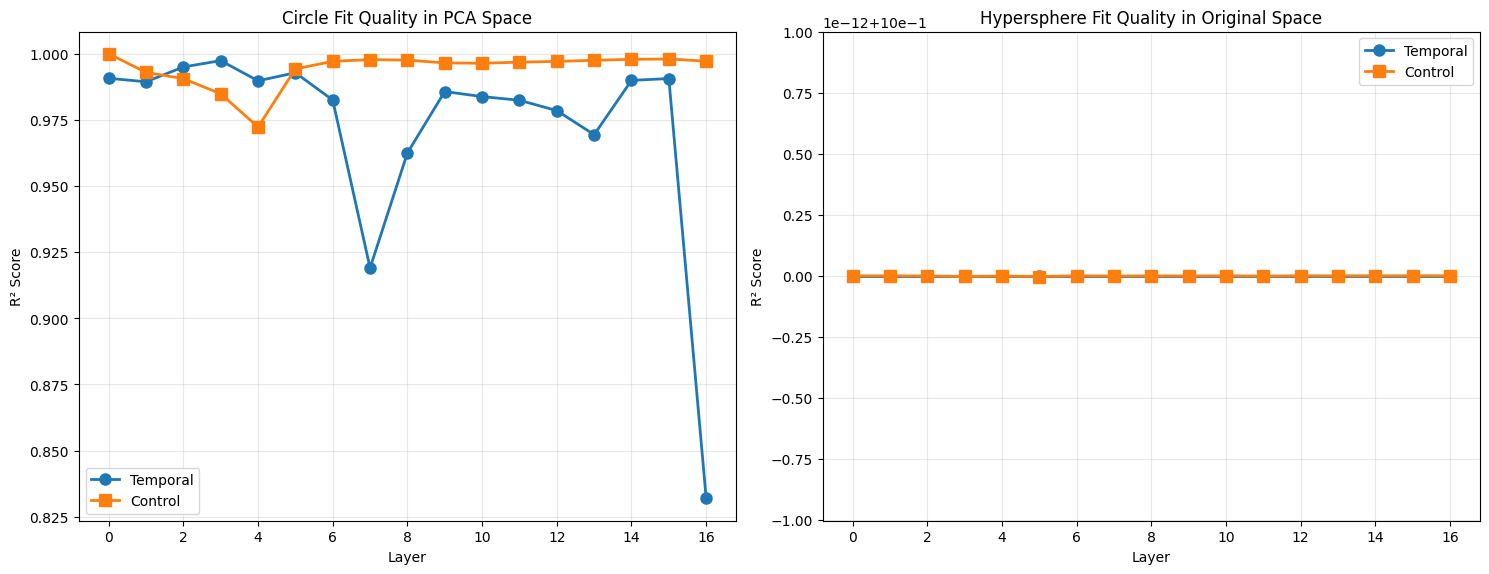

In [16]:
# Plot R² comparison across layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PCA Space R²
ax1.plot(temporal_summary['layer'], temporal_summary['pca_r2'], 
         'o-', label='Temporal', linewidth=2, markersize=8)
ax1.plot(control_summary['layer'], control_summary['pca_r2'], 
         's-', label='Control', linewidth=2, markersize=8)
ax1.set_xlabel('Layer')
ax1.set_ylabel('R² Score')
ax1.set_title('Circle Fit Quality in PCA Space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Original Space R²
ax2.plot(temporal_summary['layer'], temporal_summary['orig_r2'], 
         'o-', label='Temporal', linewidth=2, markersize=8)
ax2.plot(control_summary['layer'], control_summary['orig_r2'], 
         's-', label='Control', linewidth=2, markersize=8)
ax2.set_xlabel('Layer')
ax2.set_ylabel('R² Score')
ax2.set_title('Hypersphere Fit Quality in Original Space')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Create circle_fitting subfolder if it doesn't exist
import os
os.makedirs('../notebooks/plots/circle_fitting', exist_ok=True)

plt.savefig('../notebooks/plots/circle_fitting/r2_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


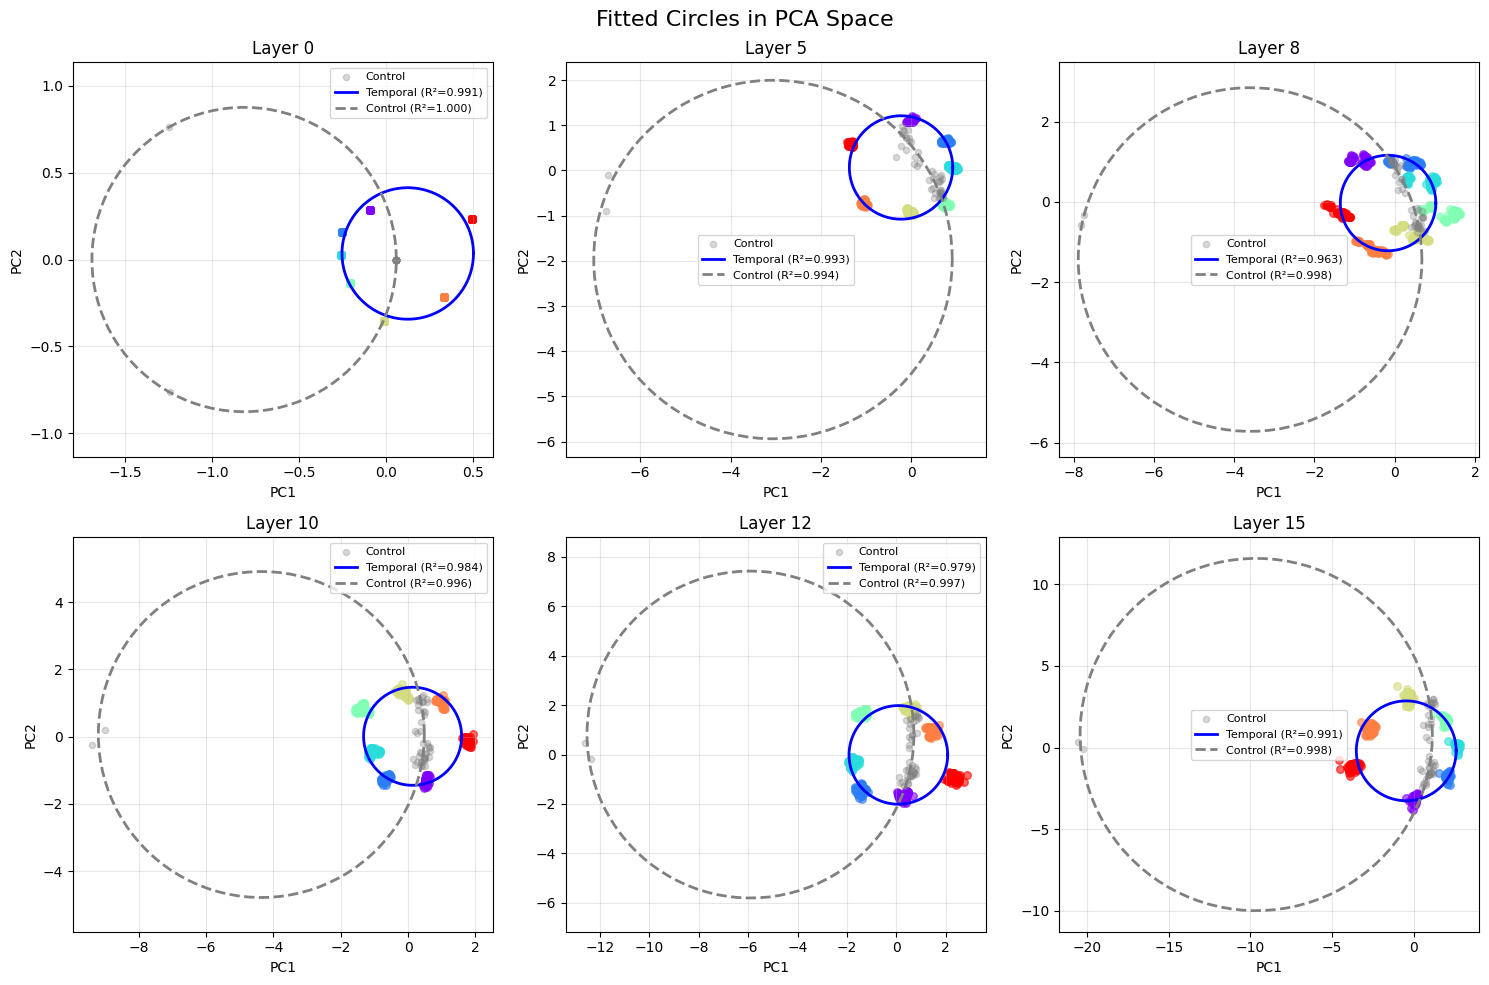

In [17]:
# Visualize fitted circles in PCA space for selected layers
layers_to_viz = [0, 5, 8, 10, 12, 15]
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for idx, layer_idx in enumerate(layers_to_viz):
    ax = axes[idx]
    
    # Get temporal PCA data and circle
    temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
    temp_center = temporal_pca_results[layer_idx]['center']
    temp_radius = temporal_pca_results[layer_idx]['radius']
    temp_r2 = temporal_pca_results[layer_idx]['r2']
    
    # Get control PCA data and circle
    ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
    ctrl_center = control_pca_results[layer_idx]['center']
    ctrl_radius = control_pca_results[layer_idx]['radius']
    ctrl_r2 = control_pca_results[layer_idx]['r2']
    
    # Plot temporal data points (colored by day)
    days_colors = plt.cm.rainbow(np.linspace(0, 1, 7))
    for day in range(7):
        mask = [label == day for label in temporal_labels]
        ax.scatter(temp_pca[mask, 0], temp_pca[mask, 1], 
                  c=[days_colors[day]], alpha=0.6, s=30)
    
    # Plot control data points
    ax.scatter(ctrl_pca[:, 0], ctrl_pca[:, 1], 
              c='gray', alpha=0.3, s=20, label='Control')
    
    # Draw fitted circles
    theta = np.linspace(0, 2*np.pi, 100)
    
    # Temporal circle
    temp_circle_x = temp_center[0] + temp_radius * np.cos(theta)
    temp_circle_y = temp_center[1] + temp_radius * np.sin(theta)
    ax.plot(temp_circle_x, temp_circle_y, 'b-', linewidth=2, 
            label=f'Temporal (R²={temp_r2:.3f})')
    
    # Control circle
    ctrl_circle_x = ctrl_center[0] + ctrl_radius * np.cos(theta)
    ctrl_circle_y = ctrl_center[1] + ctrl_radius * np.sin(theta)
    ax.plot(ctrl_circle_x, ctrl_circle_y, 'gray', linewidth=2, linestyle='--',
            label=f'Control (R²={ctrl_r2:.3f})')
    
    ax.set_title(f'Layer {layer_idx}')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.axis('equal')

plt.suptitle('Fitted Circles in PCA Space', fontsize=16)
plt.tight_layout()
plt.savefig('../notebooks/plots/circle_fitting/pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


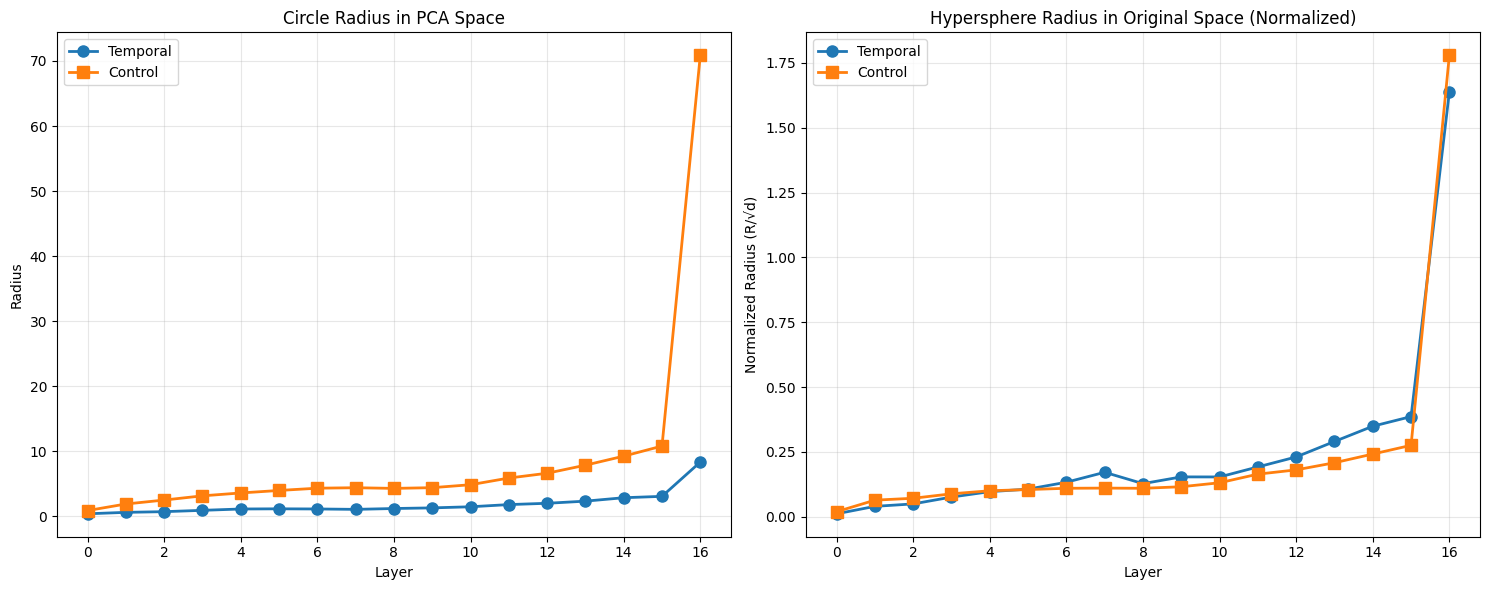

In [18]:
# Compare radius evolution across layers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PCA Space Radii
ax1.plot(temporal_summary['layer'], temporal_summary['pca_radius'], 
         'o-', label='Temporal', linewidth=2, markersize=8)
ax1.plot(control_summary['layer'], control_summary['pca_radius'], 
         's-', label='Control', linewidth=2, markersize=8)
ax1.set_xlabel('Layer')
ax1.set_ylabel('Radius')
ax1.set_title('Circle Radius in PCA Space')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Original Space Radii (normalized by sqrt(dims) for comparability)
temp_normalized_radius = temporal_summary['orig_radius'] / np.sqrt(temporal_summary['orig_dims'])
ctrl_normalized_radius = control_summary['orig_radius'] / np.sqrt(control_summary['orig_dims'])

ax2.plot(temporal_summary['layer'], temp_normalized_radius, 
         'o-', label='Temporal', linewidth=2, markersize=8)
ax2.plot(control_summary['layer'], ctrl_normalized_radius, 
         's-', label='Control', linewidth=2, markersize=8)
ax2.set_xlabel('Layer')
ax2.set_ylabel('Normalized Radius (R/√d)')
ax2.set_title('Hypersphere Radius in Original Space (Normalized)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../notebooks/plots/circle_fitting/radius_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# Find best layer based on R² in PCA space for temporal data
best_layer_pca = temporal_summary.loc[temporal_summary['pca_r2'].idxmax(), 'layer']
best_r2_pca = temporal_summary.loc[temporal_summary['pca_r2'].idxmax(), 'pca_r2']

print(f"Best layer for temporal circle fit in PCA space: Layer {int(best_layer_pca)}")
print(f"R² score: {best_r2_pca:.4f}")

# Compare with control at same layer
control_r2_at_best = control_summary[control_summary['layer'] == best_layer_pca]['pca_r2'].values[0]
print(f"\nControl R² at layer {int(best_layer_pca)}: {control_r2_at_best:.4f}")
print(f"Difference: {best_r2_pca - control_r2_at_best:.4f}")


Best layer for temporal circle fit in PCA space: Layer 3
R² score: 0.9974

Control R² at layer 3: 0.9849
Difference: 0.0125


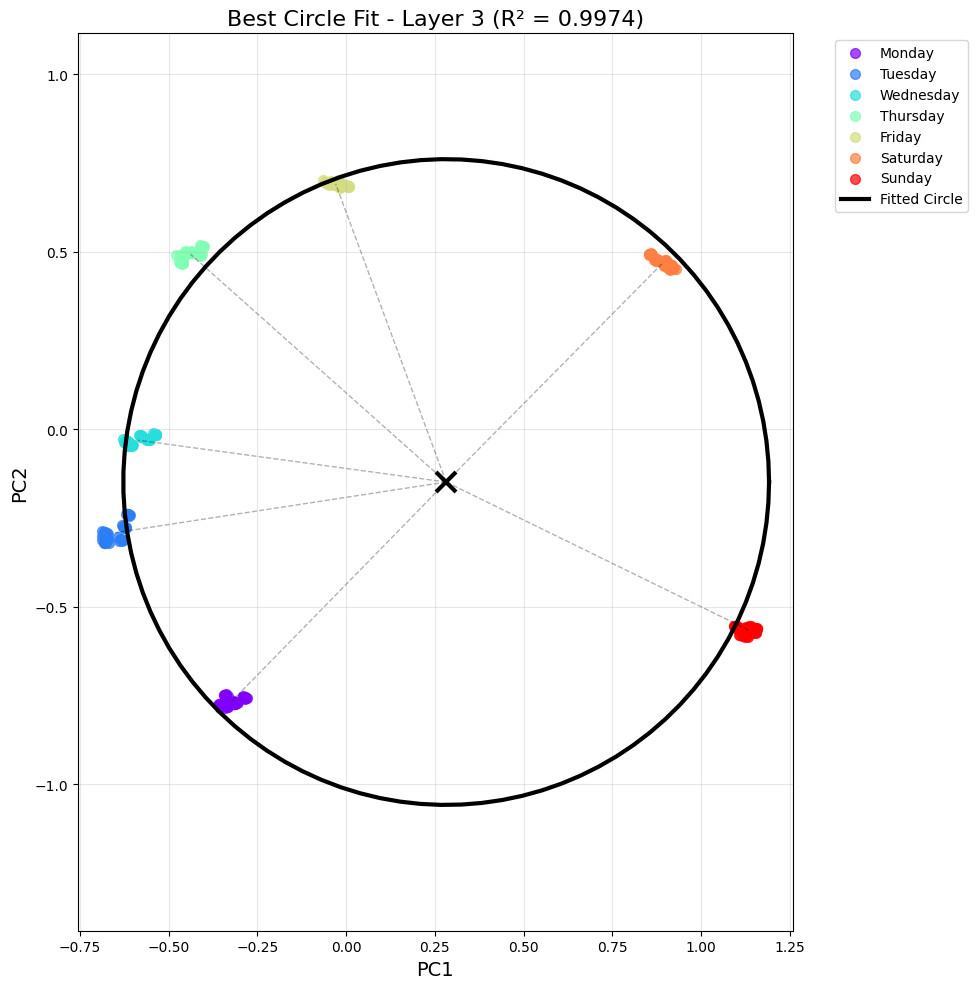

In [20]:
# Detailed visualization of best layer
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

layer_idx = int(best_layer_pca)

# Get data
temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
temp_center = temporal_pca_results[layer_idx]['center']
temp_radius = temporal_pca_results[layer_idx]['radius']

# Plot points colored by RESULT day (not origin day)
# E.g., "Monday + 3 days = Thursday" will be colored as Thursday
days_colors = plt.cm.rainbow(np.linspace(0, 1, 7))
days_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in range(7):
    # temporal_labels contains result_day values, so this masks by result day
    mask = [label == day for label in temporal_labels]
    ax.scatter(temp_pca[mask, 0], temp_pca[mask, 1], 
              c=[days_colors[day]], alpha=0.7, s=50, label=days_names[day])

# Draw fitted circle
theta = np.linspace(0, 2*np.pi, 100)
circle_x = temp_center[0] + temp_radius * np.cos(theta)
circle_y = temp_center[1] + temp_radius * np.sin(theta)
ax.plot(circle_x, circle_y, 'k-', linewidth=3, label='Fitted Circle')

# Mark center
ax.plot(temp_center[0], temp_center[1], 'kx', markersize=15, markeredgewidth=3)

# Add radial lines to show structure
for day in range(7):
    mask = [label == day for label in temporal_labels]
    day_mean = np.mean(temp_pca[mask], axis=0)
    ax.plot([temp_center[0], day_mean[0]], [temp_center[1], day_mean[1]], 
            'k--', alpha=0.3, linewidth=1)

ax.set_title(f'Best Circle Fit - Layer {layer_idx} (R² = {best_r2_pca:.4f})', fontsize=16)
ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.axis('equal')

plt.tight_layout()
plt.savefig('../notebooks/plots/circle_fitting/best_layer.png', dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Save numerical results
all_results.to_csv('../notebooks/circle_fitting_results.csv', index=False)
print("Results saved to circle_fitting_results.csv")

# Create detailed results dictionary for further analysis
detailed_results = {
    'temporal_pca': temporal_pca_results,
    'temporal_orig': temporal_orig_results,
    'control_pca': control_pca_results,
    'control_orig': control_orig_results,
    'summary': all_results
}

# Save with pickle for later use
import pickle
with open('../notebooks/circle_fitting_detailed_results.pkl', 'wb') as f:
    pickle.dump(detailed_results, f)
print("Detailed results saved to circle_fitting_detailed_results.pkl")


Results saved to circle_fitting_results.csv
Detailed results saved to circle_fitting_detailed_results.pkl


In [22]:
def create_interactive_circle_visualization(
    temporal_pca_results: Dict,
    control_pca_results: Dict,
    temporal_labels: List,
    temporal_summary: pd.DataFrame,
    control_summary: pd.DataFrame,
    space_type: str = "PCA"
):
    """
    Create interactive visualization with layer selection for circle fitting results.
    
    Args:
        temporal_pca_results: PCA results for temporal data
        control_pca_results: PCA results for control data
        temporal_labels: Labels for temporal data points
        temporal_summary: Summary statistics for temporal data
        control_summary: Summary statistics for control data
        space_type: "PCA" or "Original" for display purposes
    """
    
    # Get list of layers
    layers = sorted(temporal_pca_results.keys())
    
    # Create figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Temporal Data", "Control Data"),
        specs=[[{"type": "scatter"}, {"type": "scatter"}]],
        horizontal_spacing=0.15
    )
    
    # Days of week for coloring
    days_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_colors = px.colors.qualitative.Set3[:7]
    
    # Add traces for each layer
    for layer_idx in layers:
        # Temporal data
        temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
        temp_center = temporal_pca_results[layer_idx]['center']
        temp_radius = temporal_pca_results[layer_idx]['radius']
        temp_r2 = temporal_summary[temporal_summary['layer'] == layer_idx]['pca_r2'].values[0]
        
        # Add temporal data points by day
        for day in range(7):
            mask = [label == day for label in temporal_labels]
            day_points = temp_pca[mask]
            
            fig.add_trace(
                go.Scatter(
                    x=day_points[:, 0],
                    y=day_points[:, 1],
                    mode='markers',
                    name=days_names[day],
                    marker=dict(color=days_colors[day], size=8),
                    showlegend=(layer_idx == layers[0]),  # Only show legend for first layer
                    visible=(layer_idx == layers[0]),  # Only first layer visible initially
                    legendgroup=f"day_{day}",
                    hovertemplate=f"{days_names[day]}<br>PC1: %{{x:.3f}}<br>PC2: %{{y:.3f}}<extra></extra>"
                ),
                row=1, col=1
            )
        
        # Add temporal fitted circle
        theta = np.linspace(0, 2*np.pi, 100)
        circle_x = temp_center[0] + temp_radius * np.cos(theta)
        circle_y = temp_center[1] + temp_radius * np.sin(theta)
        
        fig.add_trace(
            go.Scatter(
                x=circle_x,
                y=circle_y,
                mode='lines',
                name=f'Fitted Circle (R²={temp_r2:.3f})',
                line=dict(color='black', width=3),
                showlegend=(layer_idx == layers[0]),
                visible=(layer_idx == layers[0]),
                hovertemplate=f"Temporal Circle<br>R²={temp_r2:.3f}<br>Radius={temp_radius:.3f}<extra></extra>"
            ),
            row=1, col=1
        )
        
        # Add center point
        fig.add_trace(
            go.Scatter(
                x=[temp_center[0]],
                y=[temp_center[1]],
                mode='markers',
                marker=dict(symbol='x', size=15, color='black'),
                name='Center',
                showlegend=False,
                visible=(layer_idx == layers[0]),
                hovertemplate=f"Center<br>PC1: {temp_center[0]:.3f}<br>PC2: {temp_center[1]:.3f}<extra></extra>"
            ),
            row=1, col=1
        )
        
        # Control data
        ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
        ctrl_center = control_pca_results[layer_idx]['center']
        ctrl_radius = control_pca_results[layer_idx]['radius']
        ctrl_r2 = control_summary[control_summary['layer'] == layer_idx]['pca_r2'].values[0]
        
        # Add control data points
        fig.add_trace(
            go.Scatter(
                x=ctrl_pca[:, 0],
                y=ctrl_pca[:, 1],
                mode='markers',
                name='Control Words',
                marker=dict(color='gray', size=6, opacity=0.6),
                showlegend=(layer_idx == layers[0]),
                visible=(layer_idx == layers[0]),
                hovertemplate="Control Word<br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<extra></extra>"
            ),
            row=1, col=2
        )
        
        # Add control fitted circle
        ctrl_circle_x = ctrl_center[0] + ctrl_radius * np.cos(theta)
        ctrl_circle_y = ctrl_center[1] + ctrl_radius * np.sin(theta)
        
        fig.add_trace(
            go.Scatter(
                x=ctrl_circle_x,
                y=ctrl_circle_y,
                mode='lines',
                name=f'Control Circle (R²={ctrl_r2:.3f})',
                line=dict(color='gray', width=3, dash='dash'),
                showlegend=(layer_idx == layers[0]),
                visible=(layer_idx == layers[0]),
                hovertemplate=f"Control Circle<br>R²={ctrl_r2:.3f}<br>Radius={ctrl_radius:.3f}<extra></extra>"
            ),
            row=1, col=2
        )
        
        # Add control center
        fig.add_trace(
            go.Scatter(
                x=[ctrl_center[0]],
                y=[ctrl_center[1]],
                mode='markers',
                marker=dict(symbol='x', size=15, color='gray'),
                showlegend=False,
                visible=(layer_idx == layers[0]),
                hovertemplate=f"Center<br>PC1: {ctrl_center[0]:.3f}<br>PC2: {ctrl_center[1]:.3f}<extra></extra>"
            ),
            row=1, col=2
        )
    
    # Calculate number of traces per layer
    traces_per_layer = 7 + 2 + 3  # 7 days + 2 temporal traces (circle, center) + 3 control traces (points, circle, center)
    
    # Create slider steps
    steps = []
    for i, layer_idx in enumerate(layers):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": f"Circle Fitting in {space_type} Space - Layer {layer_idx}"}],
            label=f"Layer {layer_idx}"
        )
        
        # Make traces for this layer visible
        for j in range(traces_per_layer):
            step["args"][0]["visible"][i * traces_per_layer + j] = True
        
        steps.append(step)
    
    # Add slider
    sliders = [dict(
        active=0,
        yanchor="top",
        xanchor="left",
        currentvalue=dict(
            font=dict(size=20),
            prefix="Layer: ",
            visible=True,
            xanchor="right"
        ),
        transition=dict(duration=300, easing="cubic-in-out"),
        pad=dict(b=10, t=50),
        len=0.9,
        x=0.1,
        y=0,
        steps=steps
    )]
    
    # Update layout
    fig.update_layout(
        sliders=sliders,
        title=f"Circle Fitting in {space_type} Space - Layer 0",
        height=600,
        showlegend=True,
        hovermode='closest',
        template='plotly_white'
    )
    
    # Update axes
    fig.update_xaxes(title_text="PC1", row=1, col=1, scaleanchor="y", scaleratio=1)
    fig.update_yaxes(title_text="PC2", row=1, col=1)
    fig.update_xaxes(title_text="PC1", row=1, col=2, scaleanchor="y", scaleratio=1)
    fig.update_yaxes(title_text="PC2", row=1, col=2)
    
    return fig

# Create interactive visualization for PCA space
fig_pca = create_interactive_circle_visualization(
    temporal_pca_results,
    control_pca_results,
    temporal_labels,
    temporal_summary,
    control_summary,
    space_type="PCA"
)

# Save as HTML
fig_pca.write_html('../html/circle_fitting_interactive_pca.html')
print("Saved interactive PCA visualization to ../html/circle_fitting_interactive_pca.html")

# Display in notebook
fig_pca.show()


Saved interactive PCA visualization to ../html/circle_fitting_interactive_pca.html


In [23]:
# Create visualization for original embedding space
# Note: We still use PCA for visualization, but display original space metrics
def create_original_space_visualization(
    temporal_pca_results: Dict,
    control_pca_results: Dict,
    temporal_orig_results: Dict,
    control_orig_results: Dict,
    temporal_labels: List,
    temporal_summary: pd.DataFrame,
    control_summary: pd.DataFrame
):
    """
    Create interactive visualization for original embedding space analysis.
    Uses PCA for visualization but shows original space metrics.
    """
    
    # Get list of layers
    layers = sorted(temporal_pca_results.keys())
    
    # Create figure with subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=("Temporal Data", "Control Data"),
        specs=[[{"type": "scatter"}, {"type": "scatter"}]],
        horizontal_spacing=0.15
    )
    
    # Days of week for coloring
    days_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    days_colors = px.colors.qualitative.Set3[:7]
    
    # Add traces for each layer
    for layer_idx in layers:
        # Get PCA projections for visualization
        temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
        ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
        
        # Get original space metrics
        temp_orig_radius = temporal_orig_results[layer_idx]['radius']
        temp_orig_r2 = temporal_summary[temporal_summary['layer'] == layer_idx]['orig_r2'].values[0]
        temp_n_dims = temporal_orig_results[layer_idx]['n_dims']
        
        ctrl_orig_radius = control_orig_results[layer_idx]['radius']
        ctrl_orig_r2 = control_summary[control_summary['layer'] == layer_idx]['orig_r2'].values[0]
        
        # Add temporal data points by day
        for day in range(7):
            mask = [label == day for label in temporal_labels]
            day_points = temp_pca[mask]
            
            fig.add_trace(
                go.Scatter(
                    x=day_points[:, 0],
                    y=day_points[:, 1],
                    mode='markers',
                    name=days_names[day],
                    marker=dict(color=days_colors[day], size=8),
                    showlegend=(layer_idx == layers[0]),
                    visible=(layer_idx == layers[0]),
                    legendgroup=f"day_{day}",
                    hovertemplate=f"{days_names[day]}<br>PC1: %{{x:.3f}}<br>PC2: %{{y:.3f}}<extra></extra>"
                ),
                row=1, col=1
            )
        
        # Add control data points
        fig.add_trace(
            go.Scatter(
                x=ctrl_pca[:, 0],
                y=ctrl_pca[:, 1],
                mode='markers',
                name='Control Words',
                marker=dict(color='gray', size=6, opacity=0.6),
                showlegend=(layer_idx == layers[0]),
                visible=(layer_idx == layers[0]),
                hovertemplate="Control Word<br>PC1: %{x:.3f}<br>PC2: %{y:.3f}<extra></extra>"
            ),
            row=1, col=2
        )
        
        # Add text annotations for original space metrics
        fig.add_annotation(
            text=f"<b>Original Space Metrics:</b><br>" +
                 f"Hypersphere Radius: {temp_orig_radius:.2f}<br>" +
                 f"R²: {temp_orig_r2:.3f}<br>" +
                 f"Dimensions: {temp_n_dims}",
            xref="x", yref="y",
            x=0.95, y=0.95,
            xanchor="right", yanchor="top",
            showarrow=False,
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="black",
            borderwidth=1,
            font=dict(size=12),
            visible=(layer_idx == layers[0]),
            row=1, col=1
        )
        
        fig.add_annotation(
            text=f"<b>Original Space Metrics:</b><br>" +
                 f"Hypersphere Radius: {ctrl_orig_radius:.2f}<br>" +
                 f"R²: {ctrl_orig_r2:.3f}<br>" +
                 f"Dimensions: {temp_n_dims}",
            xref="x2", yref="y2",
            x=0.95, y=0.95,
            xanchor="right", yanchor="top",
            showarrow=False,
            bgcolor="rgba(255,255,255,0.8)",
            bordercolor="gray",
            borderwidth=1,
            font=dict(size=12),
            visible=(layer_idx == layers[0]),
            row=1, col=2
        )
    
    # Calculate number of traces per layer
    traces_per_layer = 7 + 1  # 7 days + 1 control trace
    annotations_per_layer = 2  # 2 text annotations
    
    # Create slider steps
    steps = []
    for i, layer_idx in enumerate(layers):
        step = dict(
            method="update",
            args=[
                {"visible": [False] * len(fig.data)},
                {"title": f"Original Embedding Space Analysis - Layer {layer_idx} ({temporal_orig_results[layer_idx]['n_dims']}D)",
                 "annotations": [a for a in fig.layout.annotations if i * annotations_per_layer <= fig.layout.annotations.index(a) < (i + 1) * annotations_per_layer]}
            ],
            label=f"Layer {layer_idx}"
        )
        
        # Make traces for this layer visible
        for j in range(traces_per_layer):
            step["args"][0]["visible"][i * traces_per_layer + j] = True
        
        # Make annotations for this layer visible
        for j, ann in enumerate(fig.layout.annotations):
            if i * annotations_per_layer <= j < (i + 1) * annotations_per_layer:
                ann.visible = (i == 0)  # Only first layer visible initially
        
        steps.append(step)
    
    # Add slider
    sliders = [dict(
        active=0,
        yanchor="top",
        xanchor="left",
        currentvalue=dict(
            font=dict(size=20),
            prefix="Layer: ",
            visible=True,
            xanchor="right"
        ),
        transition=dict(duration=300, easing="cubic-in-out"),
        pad=dict(b=10, t=50),
        len=0.9,
        x=0.1,
        y=0,
        steps=steps
    )]
    
    # Update layout
    fig.update_layout(
        sliders=sliders,
        title=f"Original Embedding Space Analysis - Layer 0 ({temporal_orig_results[0]['n_dims']}D)",
        height=600,
        showlegend=True,
        hovermode='closest',
        template='plotly_white'
    )
    
    # Update axes
    fig.update_xaxes(title_text="PC1 (for visualization)", row=1, col=1)
    fig.update_yaxes(title_text="PC2 (for visualization)", row=1, col=1)
    fig.update_xaxes(title_text="PC1 (for visualization)", row=1, col=2)
    fig.update_yaxes(title_text="PC2 (for visualization)", row=1, col=2)
    
    return fig

# Create visualization for original space
fig_orig = create_original_space_visualization(
    temporal_pca_results,
    control_pca_results,
    temporal_orig_results,
    control_orig_results,
    temporal_labels,
    temporal_summary,
    control_summary
)

# Save as HTML
fig_orig.write_html('../html/circle_fitting_interactive_original.html')
print("Saved interactive original space visualization to ../html/circle_fitting_interactive_original.html")

# Display in notebook
fig_orig.show()


Saved interactive original space visualization to ../html/circle_fitting_interactive_original.html


In [24]:
def fit_circle_fixed_center_2d(points: np.ndarray, center: np.ndarray) -> Tuple[float, float, float]:
    """
    Fit a circle with fixed center to 2D points.
    
    Args:
        points: (n, 2) array of 2D points
        center: (2,) array specifying the fixed center
        
    Returns:
        tuple: (radius, mse, r2)
    """
    # Calculate distances from fixed center
    distances = np.linalg.norm(points - center, axis=1)
    
    # Radius is the mean distance
    radius = np.mean(distances)
    
    # Calculate error metrics
    mse = mean_squared_error(distances, np.full_like(distances, radius))
    
    # Calculate R² - proportion of variance explained by the circle model
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    predicted_points = np.column_stack([
        center[0] + radius * np.cos(angles),
        center[1] + radius * np.sin(angles)
    ])
    
    # Calculate residual sum of squares
    ss_res = np.sum((points - predicted_points)**2)
    
    # Calculate total sum of squares (variance from centroid)
    centroid = np.mean(points, axis=0)
    ss_tot = np.sum((points - centroid)**2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return radius, mse, r2


def calculate_span_metrics(points: np.ndarray) -> Dict[str, float]:
    """
    Calculate span metrics for a set of points.
    
    Args:
        points: (n, d) array of points
        
    Returns:
        dict: Contains span_x, span_y, max_distance, mean_pairwise_distance
    """
    if points.shape[1] >= 2:
        span_x = np.max(points[:, 0]) - np.min(points[:, 0])
        span_y = np.max(points[:, 1]) - np.min(points[:, 1])
    else:
        span_x = span_y = 0
    
    # Calculate pairwise distances
    from scipy.spatial.distance import pdist
    pairwise_distances = pdist(points)
    
    return {
        'span_x': span_x,
        'span_y': span_y,
        'max_span': max(span_x, span_y) if points.shape[1] >= 2 else 0,
        'diagonal_span': np.sqrt(span_x**2 + span_y**2) if points.shape[1] >= 2 else 0,
        'max_pairwise_distance': np.max(pairwise_distances) if len(pairwise_distances) > 0 else 0,
        'mean_pairwise_distance': np.mean(pairwise_distances) if len(pairwise_distances) > 0 else 0,
        'std_pairwise_distance': np.std(pairwise_distances) if len(pairwise_distances) > 0 else 0
    }


def calculate_detailed_errors(points: np.ndarray, center: np.ndarray, radius: float) -> Dict[str, float]:
    """
    Calculate detailed error metrics for circle fitting.
    
    Args:
        points: (n, 2) array of 2D points
        center: (2,) array with circle center
        radius: circle radius
        
    Returns:
        dict: Various error metrics
    """
    # Calculate distances from center
    distances = np.linalg.norm(points - center, axis=1)
    
    # Radial errors (distance from perfect circle)
    radial_errors = np.abs(distances - radius)
    
    # Project points onto circle for position errors
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
    predicted_points = np.column_stack([
        center[0] + radius * np.cos(angles),
        center[1] + radius * np.sin(angles)
    ])
    
    # Position errors (Euclidean distance from predicted position)
    position_errors = np.linalg.norm(points - predicted_points, axis=1)
    
    return {
        'mean_radial_error': np.mean(radial_errors),
        'std_radial_error': np.std(radial_errors),
        'max_radial_error': np.max(radial_errors),
        'mean_position_error': np.mean(position_errors),
        'std_position_error': np.std(position_errors),
        'max_position_error': np.max(position_errors),
        'relative_radial_error': np.mean(radial_errors) / radius if radius > 0 else np.inf,
        'coefficient_of_variation': np.std(distances) / np.mean(distances) if np.mean(distances) > 0 else np.inf
    }


In [25]:
# Fit circles with fixed center (centroid) for control words
control_fixed_center_results = {}

for layer_idx, embeddings in control_layer_reprs.items():
    # Apply PCA
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(embeddings)
    
    # Calculate centroid
    centroid = np.mean(pca_transformed, axis=0)
    
    # Fit circle with fixed center
    radius_fixed, mse_fixed, r2_fixed = fit_circle_fixed_center_2d(pca_transformed, centroid)
    
    # Compare with original optimized fit
    original_result = control_pca_results[layer_idx]
    
    control_fixed_center_results[layer_idx] = {
        'center': centroid,
        'radius': radius_fixed,
        'mse': mse_fixed,
        'r2': r2_fixed,
        'original_center': original_result['center'],
        'original_radius': original_result['radius'],
        'original_r2': original_result['r2'],
        'center_shift': np.linalg.norm(centroid - original_result['center'])
    }

# Display comparison
print("Control Words: Fixed Center vs. Optimized Circle Fitting")
print("="*80)
print(f"{'Layer':<6} {'Fixed R²':<10} {'Orig R²':<10} {'Fixed Rad':<10} {'Orig Rad':<10} {'Center Shift':<12}")
print("-"*80)

for layer_idx in sorted(control_fixed_center_results.keys()):
    result = control_fixed_center_results[layer_idx]
    print(f"{layer_idx:<6} {result['r2']:<10.4f} {result['original_r2']:<10.4f} "
          f"{result['radius']:<10.4f} {result['original_radius']:<10.4f} "
          f"{result['center_shift']:<12.4f}")


Control Words: Fixed Center vs. Optimized Circle Fitting
Layer  Fixed R²   Orig R²    Fixed Rad  Orig Rad   Center Shift
--------------------------------------------------------------------------------
0      0.1476     1.0000     0.1203     0.8755     0.8176      
1      0.1615     0.9929     0.2941     1.8837     1.7368      
2      0.1644     0.9906     0.3960     2.4912     2.2937      
3      0.1661     0.9849     0.5032     3.1391     2.8901      
4      0.1841     0.9723     0.6080     3.5819     3.2981      
5      0.3518     0.9943     0.9370     3.9661     3.6399      
6      0.3686     0.9971     1.0468     4.3148     3.9565      
7      0.3775     0.9978     1.1094     4.3866     3.9987      
8      0.3596     0.9976     1.0912     4.2847     3.8801      
9      0.3411     0.9965     1.1122     4.3946     3.9622      
10     0.3235     0.9964     1.2050     4.8477     4.3622      
11     0.2884     0.9968     1.3387     5.8757     5.3224      
12     0.3242     0.9971     1

In [26]:
# Do the same for temporal words for comparison
temporal_fixed_center_results = {}

for layer_idx, embeddings in temporal_layer_reprs.items():
    # Apply PCA
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(embeddings)
    
    # Calculate centroid
    centroid = np.mean(pca_transformed, axis=0)
    
    # Fit circle with fixed center
    radius_fixed, mse_fixed, r2_fixed = fit_circle_fixed_center_2d(pca_transformed, centroid)
    
    # Compare with original optimized fit
    original_result = temporal_pca_results[layer_idx]
    
    temporal_fixed_center_results[layer_idx] = {
        'center': centroid,
        'radius': radius_fixed,
        'mse': mse_fixed,
        'r2': r2_fixed,
        'original_center': original_result['center'],
        'original_radius': original_result['radius'],
        'original_r2': original_result['r2'],
        'center_shift': np.linalg.norm(centroid - original_result['center'])
    }

# Display comparison
print("\nTemporal Words: Fixed Center vs. Optimized Circle Fitting")
print("="*80)
print(f"{'Layer':<6} {'Fixed R²':<10} {'Orig R²':<10} {'Fixed Rad':<10} {'Orig Rad':<10} {'Center Shift':<12}")
print("-"*80)

for layer_idx in sorted(temporal_fixed_center_results.keys()):
    result = temporal_fixed_center_results[layer_idx]
    print(f"{layer_idx:<6} {result['r2']:<10.4f} {result['original_r2']:<10.4f} "
          f"{result['radius']:<10.4f} {result['original_radius']:<10.4f} "
          f"{result['center_shift']:<12.4f}")



Temporal Words: Fixed Center vs. Optimized Circle Fitting
Layer  Fixed R²   Orig R²    Fixed Rad  Orig Rad   Center Shift
--------------------------------------------------------------------------------
0      0.9295     0.9907     0.3446     0.3782     0.1284      
1      0.9499     0.9894     0.5629     0.6001     0.1735      
2      0.9457     0.9950     0.6520     0.7053     0.2241      
3      0.9319     0.9974     0.8234     0.9095     0.3187      
4      0.9509     0.9898     1.0489     1.1162     0.3173      
5      0.9722     0.9928     1.1071     1.1437     0.2375      
6      0.9641     0.9825     1.0884     1.1203     0.2182      
7      0.9135     0.9190     1.0485     1.0589     0.1237      
8      0.9539     0.9625     1.1735     1.1905     0.1666      
9      0.9739     0.9857     1.2638     1.2872     0.2009      
10     0.9797     0.9838     1.4486     1.4581     0.1371      
11     0.9812     0.9824     1.7900     1.7931     0.0841      
12     0.9778     0.9785    

In [27]:
# Calculate span metrics for both temporal and control words
temporal_span_metrics = {}
control_span_metrics = {}

for layer_idx in temporal_pca_results.keys():
    # Temporal words span
    temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
    temporal_span_metrics[layer_idx] = calculate_span_metrics(temp_pca)
    
    # Control words span
    ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
    control_span_metrics[layer_idx] = calculate_span_metrics(ctrl_pca)

# Display span metrics comparison
print("Span Metrics Comparison (PCA Space)")
print("="*100)
print(f"{'Layer':<6} {'Dataset':<10} {'Span X':<10} {'Span Y':<10} {'Diagonal':<10} {'Max Pair':<10} {'Mean Pair':<10}")
print("-"*100)

for layer_idx in sorted(temporal_span_metrics.keys()):
    temp_span = temporal_span_metrics[layer_idx]
    ctrl_span = control_span_metrics[layer_idx]
    
    print(f"{layer_idx:<6} {'Temporal':<10} {temp_span['span_x']:<10.3f} {temp_span['span_y']:<10.3f} "
          f"{temp_span['diagonal_span']:<10.3f} {temp_span['max_pairwise_distance']:<10.3f} "
          f"{temp_span['mean_pairwise_distance']:<10.3f}")
    print(f"{'':<6} {'Control':<10} {ctrl_span['span_x']:<10.3f} {ctrl_span['span_y']:<10.3f} "
          f"{ctrl_span['diagonal_span']:<10.3f} {ctrl_span['max_pairwise_distance']:<10.3f} "
          f"{ctrl_span['mean_pairwise_distance']:<10.3f}")
    print()


Span Metrics Comparison (PCA Space)
Layer  Dataset    Span X     Span Y     Diagonal   Max Pair   Mean Pair 
----------------------------------------------------------------------------------------------------
0      Temporal   0.755      0.641      0.991      0.794      0.434     
       Control    1.306      1.527      2.009      1.527      0.133     

1      Temporal   1.235      1.011      1.596      1.334      0.709     
       Control    3.542      2.399      4.278      3.722      0.375     

2      Temporal   1.389      1.180      1.823      1.516      0.823     
       Control    4.648      3.085      5.578      4.887      0.520     

3      Temporal   1.846      1.488      2.371      1.948      1.041     
       Control    5.877      3.882      7.043      6.179      0.685     

4      Temporal   2.464      1.980      3.161      2.624      1.335     
       Control    6.753      4.362      8.040      7.094      0.863     

5      Temporal   2.458      2.189      3.292      2.67

In [28]:
# Calculate detailed error metrics for both datasets
temporal_error_metrics = {}
control_error_metrics = {}

for layer_idx in temporal_pca_results.keys():
    # Temporal errors
    temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
    temp_center = temporal_pca_results[layer_idx]['center']
    temp_radius = temporal_pca_results[layer_idx]['radius']
    temporal_error_metrics[layer_idx] = calculate_detailed_errors(temp_pca, temp_center, temp_radius)
    
    # Control errors
    ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
    ctrl_center = control_pca_results[layer_idx]['center']
    ctrl_radius = control_pca_results[layer_idx]['radius']
    control_error_metrics[layer_idx] = calculate_detailed_errors(ctrl_pca, ctrl_center, ctrl_radius)

# Display detailed error metrics
print("Detailed Error Metrics Comparison")
print("="*120)
print(f"{'Layer':<6} {'Dataset':<10} {'Mean Rad Err':<13} {'Std Rad Err':<12} {'Mean Pos Err':<13} {'Std Pos Err':<12} {'Rel Rad Err':<12} {'Coef Var':<10}")
print("-"*120)

for layer_idx in sorted(temporal_error_metrics.keys()):
    temp_err = temporal_error_metrics[layer_idx]
    ctrl_err = control_error_metrics[layer_idx]
    
    print(f"{layer_idx:<6} {'Temporal':<10} {temp_err['mean_radial_error']:<13.4f} {temp_err['std_radial_error']:<12.4f} "
          f"{temp_err['mean_position_error']:<13.4f} {temp_err['std_position_error']:<12.4f} "
          f"{temp_err['relative_radial_error']:<12.4f} {temp_err['coefficient_of_variation']:<10.4f}")
    print(f"{'':<6} {'Control':<10} {ctrl_err['mean_radial_error']:<13.4f} {ctrl_err['std_radial_error']:<12.4f} "
          f"{ctrl_err['mean_position_error']:<13.4f} {ctrl_err['std_position_error']:<12.4f} "
          f"{ctrl_err['relative_radial_error']:<12.4f} {ctrl_err['coefficient_of_variation']:<10.4f}")
    print()


Detailed Error Metrics Comparison
Layer  Dataset    Mean Rad Err  Std Rad Err  Mean Pos Err  Std Pos Err  Rel Rad Err  Coef Var  
------------------------------------------------------------------------------------------------------------------------
0      Temporal   0.0294        0.0179       0.0294        0.0179       0.0777       0.0911    
       Control    0.0000        0.0000       0.0000        0.0000       0.0000       0.0000    

1      Temporal   0.0532        0.0265       0.0532        0.0265       0.0886       0.0991    
       Control    0.0472        0.0394       0.0472        0.0394       0.0250       0.0326    

2      Temporal   0.0411        0.0238       0.0411        0.0238       0.0582       0.0673    
       Control    0.0754        0.0574       0.0754        0.0574       0.0303       0.0380    

3      Temporal   0.0375        0.0220       0.0375        0.0220       0.0412       0.0478    
       Control    0.1292        0.0798       0.1292        0.0798       0.

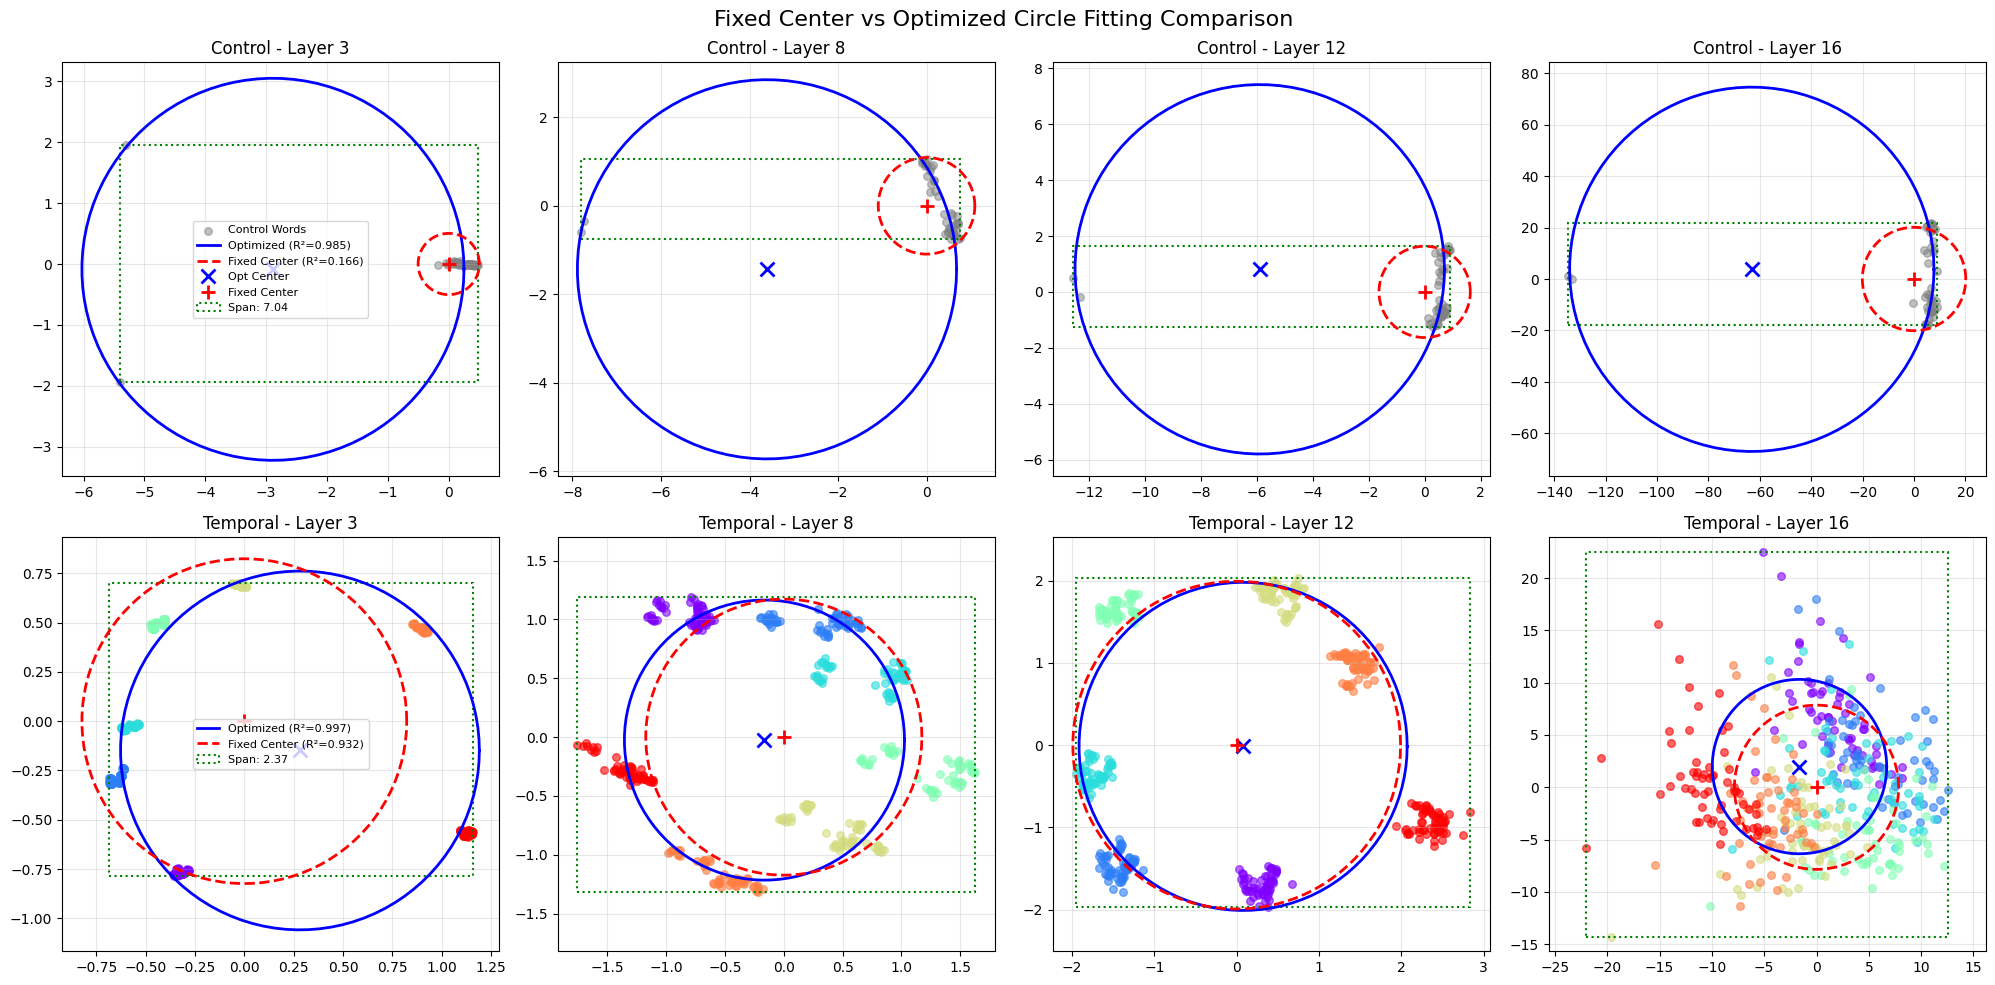

In [29]:
# Visualize fixed center vs optimized center for selected layers
layers_to_viz = [3, 8, 12, 16]
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, layer_idx in enumerate(layers_to_viz):
    # Top row: Control words
    ax_ctrl = axes[0, idx]
    ctrl_pca = control_pca_results[layer_idx]['pca_transformed']
    
    # Plot control points
    ax_ctrl.scatter(ctrl_pca[:, 0], ctrl_pca[:, 1], 
                   c='gray', alpha=0.5, s=30, label='Control Words')
    
    # Draw optimized circle
    ctrl_opt_center = control_pca_results[layer_idx]['center']
    ctrl_opt_radius = control_pca_results[layer_idx]['radius']
    ctrl_opt_r2 = control_pca_results[layer_idx]['r2']
    
    theta = np.linspace(0, 2*np.pi, 100)
    opt_circle_x = ctrl_opt_center[0] + ctrl_opt_radius * np.cos(theta)
    opt_circle_y = ctrl_opt_center[1] + ctrl_opt_radius * np.sin(theta)
    ax_ctrl.plot(opt_circle_x, opt_circle_y, 'b-', linewidth=2, 
                label=f'Optimized (R²={ctrl_opt_r2:.3f})')
    
    # Draw fixed center circle
    ctrl_fixed = control_fixed_center_results[layer_idx]
    fixed_circle_x = ctrl_fixed['center'][0] + ctrl_fixed['radius'] * np.cos(theta)
    fixed_circle_y = ctrl_fixed['center'][1] + ctrl_fixed['radius'] * np.sin(theta)
    ax_ctrl.plot(fixed_circle_x, fixed_circle_y, 'r--', linewidth=2,
                label=f'Fixed Center (R²={ctrl_fixed["r2"]:.3f})')
    
    # Mark centers
    ax_ctrl.plot(ctrl_opt_center[0], ctrl_opt_center[1], 'bx', 
                markersize=10, markeredgewidth=2, label='Opt Center')
    ax_ctrl.plot(ctrl_fixed['center'][0], ctrl_fixed['center'][1], 'r+', 
                markersize=10, markeredgewidth=2, label='Fixed Center')
    
    # Add span box
    ctrl_span = control_span_metrics[layer_idx]
    x_min, x_max = ctrl_pca[:, 0].min(), ctrl_pca[:, 0].max()
    y_min, y_max = ctrl_pca[:, 1].min(), ctrl_pca[:, 1].max()
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         fill=False, edgecolor='green', linestyle=':', linewidth=1.5,
                         label=f'Span: {ctrl_span["diagonal_span"]:.2f}')
    ax_ctrl.add_patch(rect)
    
    ax_ctrl.set_title(f'Control - Layer {layer_idx}')
    ax_ctrl.axis('equal')
    ax_ctrl.grid(True, alpha=0.3)
    if idx == 0:
        ax_ctrl.legend(fontsize=8)
    
    # Bottom row: Temporal words for comparison
    ax_temp = axes[1, idx]
    temp_pca = temporal_pca_results[layer_idx]['pca_transformed']
    
    # Plot temporal points by day
    days_colors = plt.cm.rainbow(np.linspace(0, 1, 7))
    for day in range(7):
        mask = [label == day for label in temporal_labels]
        ax_temp.scatter(temp_pca[mask, 0], temp_pca[mask, 1], 
                       c=[days_colors[day]], alpha=0.6, s=30)
    
    # Draw optimized circle
    temp_opt_center = temporal_pca_results[layer_idx]['center']
    temp_opt_radius = temporal_pca_results[layer_idx]['radius']
    temp_opt_r2 = temporal_pca_results[layer_idx]['r2']
    
    opt_circle_x = temp_opt_center[0] + temp_opt_radius * np.cos(theta)
    opt_circle_y = temp_opt_center[1] + temp_opt_radius * np.sin(theta)
    ax_temp.plot(opt_circle_x, opt_circle_y, 'b-', linewidth=2,
                label=f'Optimized (R²={temp_opt_r2:.3f})')
    
    # Draw fixed center circle
    temp_fixed = temporal_fixed_center_results[layer_idx]
    fixed_circle_x = temp_fixed['center'][0] + temp_fixed['radius'] * np.cos(theta)
    fixed_circle_y = temp_fixed['center'][1] + temp_fixed['radius'] * np.sin(theta)
    ax_temp.plot(fixed_circle_x, fixed_circle_y, 'r--', linewidth=2,
                label=f'Fixed Center (R²={temp_fixed["r2"]:.3f})')
    
    # Mark centers
    ax_temp.plot(temp_opt_center[0], temp_opt_center[1], 'bx', 
                markersize=10, markeredgewidth=2)
    ax_temp.plot(temp_fixed['center'][0], temp_fixed['center'][1], 'r+', 
                markersize=10, markeredgewidth=2)
    
    # Add span box
    temp_span = temporal_span_metrics[layer_idx]
    x_min, x_max = temp_pca[:, 0].min(), temp_pca[:, 0].max()
    y_min, y_max = temp_pca[:, 1].min(), temp_pca[:, 1].max()
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         fill=False, edgecolor='green', linestyle=':', linewidth=1.5,
                         label=f'Span: {temp_span["diagonal_span"]:.2f}')
    ax_temp.add_patch(rect)
    
    ax_temp.set_title(f'Temporal - Layer {layer_idx}')
    ax_temp.axis('equal')
    ax_temp.grid(True, alpha=0.3)
    if idx == 0:
        ax_temp.legend(fontsize=8)

plt.suptitle('Fixed Center vs Optimized Circle Fitting Comparison', fontsize=16)
plt.tight_layout()
plt.savefig('../notebooks/plots/circle_fitting/fixed_vs_optimized_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


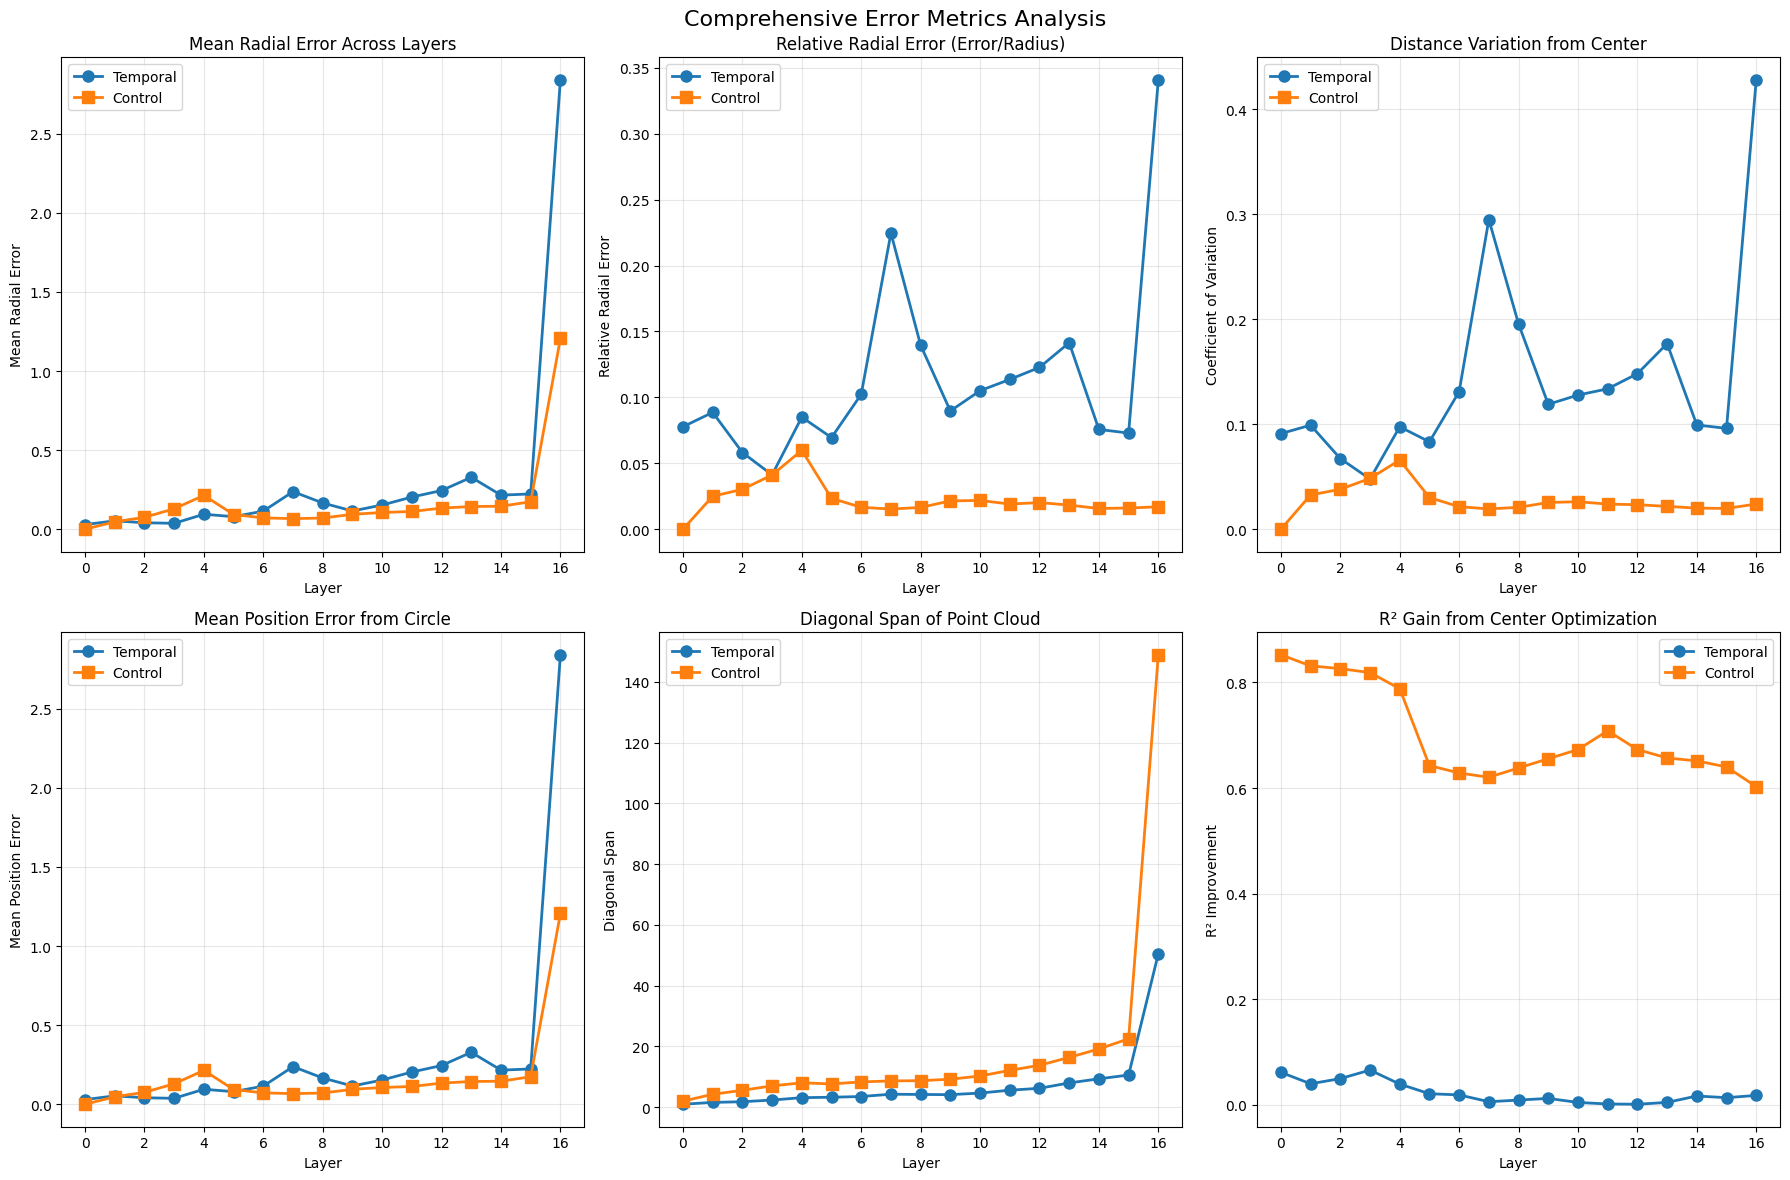

In [30]:
# Create comprehensive error metrics visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

layers = sorted(temporal_error_metrics.keys())

# Extract metrics for plotting
temp_mean_rad_err = [temporal_error_metrics[l]['mean_radial_error'] for l in layers]
ctrl_mean_rad_err = [control_error_metrics[l]['mean_radial_error'] for l in layers]

temp_rel_rad_err = [temporal_error_metrics[l]['relative_radial_error'] for l in layers]
ctrl_rel_rad_err = [control_error_metrics[l]['relative_radial_error'] for l in layers]

temp_coef_var = [temporal_error_metrics[l]['coefficient_of_variation'] for l in layers]
ctrl_coef_var = [control_error_metrics[l]['coefficient_of_variation'] for l in layers]

temp_mean_pos_err = [temporal_error_metrics[l]['mean_position_error'] for l in layers]
ctrl_mean_pos_err = [control_error_metrics[l]['mean_position_error'] for l in layers]

temp_span_diag = [temporal_span_metrics[l]['diagonal_span'] for l in layers]
ctrl_span_diag = [control_span_metrics[l]['diagonal_span'] for l in layers]

temp_r2_diff = [temporal_fixed_center_results[l]['original_r2'] - temporal_fixed_center_results[l]['r2'] for l in layers]
ctrl_r2_diff = [control_fixed_center_results[l]['original_r2'] - control_fixed_center_results[l]['r2'] for l in layers]

# Plot 1: Mean Radial Error
ax = axes[0, 0]
ax.plot(layers, temp_mean_rad_err, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_mean_rad_err, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Radial Error')
ax.set_title('Mean Radial Error Across Layers')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Relative Radial Error
ax = axes[0, 1]
ax.plot(layers, temp_rel_rad_err, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_rel_rad_err, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Relative Radial Error')
ax.set_title('Relative Radial Error (Error/Radius)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Coefficient of Variation
ax = axes[0, 2]
ax.plot(layers, temp_coef_var, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_coef_var, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Coefficient of Variation')
ax.set_title('Distance Variation from Center')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Mean Position Error
ax = axes[1, 0]
ax.plot(layers, temp_mean_pos_err, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_mean_pos_err, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Mean Position Error')
ax.set_title('Mean Position Error from Circle')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 5: Diagonal Span
ax = axes[1, 1]
ax.plot(layers, temp_span_diag, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_span_diag, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('Diagonal Span')
ax.set_title('Diagonal Span of Point Cloud')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 6: R² Improvement with Optimization
ax = axes[1, 2]
ax.plot(layers, temp_r2_diff, 'o-', label='Temporal', linewidth=2, markersize=8)
ax.plot(layers, ctrl_r2_diff, 's-', label='Control', linewidth=2, markersize=8)
ax.set_xlabel('Layer')
ax.set_ylabel('R² Improvement')
ax.set_title('R² Gain from Center Optimization')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Error Metrics Analysis', fontsize=16)
plt.tight_layout()
plt.savefig('../notebooks/plots/circle_fitting/error_metrics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


In [31]:
# Create a summary comparison table for key layers
key_layers = [3, 8, 12, 16]
summary_data = []

for layer_idx in key_layers:
    # Temporal metrics
    summary_data.append({
        'Layer': layer_idx,
        'Dataset': 'Temporal',
        'R² (Optimized)': temporal_pca_results[layer_idx]['r2'],
        'R² (Fixed Center)': temporal_fixed_center_results[layer_idx]['r2'],
        'Mean Radial Error': temporal_error_metrics[layer_idx]['mean_radial_error'],
        'Relative Error': temporal_error_metrics[layer_idx]['relative_radial_error'],
        'Coef. Variation': temporal_error_metrics[layer_idx]['coefficient_of_variation'],
        'Diagonal Span': temporal_span_metrics[layer_idx]['diagonal_span'],
        'Span/Radius Ratio': temporal_span_metrics[layer_idx]['diagonal_span'] / temporal_pca_results[layer_idx]['radius']
    })
    
    # Control metrics
    summary_data.append({
        'Layer': layer_idx,
        'Dataset': 'Control',
        'R² (Optimized)': control_pca_results[layer_idx]['r2'],
        'R² (Fixed Center)': control_fixed_center_results[layer_idx]['r2'],
        'Mean Radial Error': control_error_metrics[layer_idx]['mean_radial_error'],
        'Relative Error': control_error_metrics[layer_idx]['relative_radial_error'],
        'Coef. Variation': control_error_metrics[layer_idx]['coefficient_of_variation'],
        'Diagonal Span': control_span_metrics[layer_idx]['diagonal_span'],
        'Span/Radius Ratio': control_span_metrics[layer_idx]['diagonal_span'] / control_pca_results[layer_idx]['radius']
    })

summary_df = pd.DataFrame(summary_data)

# Display the summary
print("\nComprehensive Metrics Summary for Key Layers")
print("="*120)
print(summary_df.round(4).to_string(index=False))

# Save the summary
summary_df.to_csv('../notebooks/circle_fitting_improved_metrics.csv', index=False)
print("\nSummary saved to circle_fitting_improved_metrics.csv")



Comprehensive Metrics Summary for Key Layers
 Layer  Dataset  R² (Optimized)  R² (Fixed Center)  Mean Radial Error  Relative Error  Coef. Variation  Diagonal Span  Span/Radius Ratio
     3 Temporal          0.9974             0.9319             0.0375          0.0412           0.0478       2.370800             2.6067
     3  Control          0.9849             0.1661             0.1292          0.0412           0.0484       7.042900             2.2436
     8 Temporal          0.9625             0.9539             0.1661          0.1395           0.1954       4.208900             3.5354
     8  Control          0.9976             0.3596             0.0709          0.0165           0.0208       8.749800             2.0421
    12 Temporal          0.9785             0.9778             0.2447          0.1227           0.1481       6.238900             3.1282
    12  Control          0.9971             0.3242             0.1337          0.0202           0.0234      13.810700             2.

In [32]:
# Create a combined metrics visualization
def create_metrics_comparison_visualization(
    temporal_summary: pd.DataFrame,
    control_summary: pd.DataFrame
):
    """
    Create interactive visualization comparing R² metrics across layers and spaces.
    """
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("R² in PCA Space", "R² in Original Space", 
                       "Radius in PCA Space", "Normalized Radius in Original Space"),
        vertical_spacing=0.15,
        horizontal_spacing=0.12
    )
    
    # R² in PCA Space
    fig.add_trace(
        go.Scatter(
            x=temporal_summary['layer'],
            y=temporal_summary['pca_r2'],
            mode='lines+markers',
            name='Temporal',
            line=dict(color='blue', width=3),
            marker=dict(size=10),
            hovertemplate="Layer %{x}<br>R²: %{y:.3f}<extra></extra>"
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=control_summary['layer'],
            y=control_summary['pca_r2'],
            mode='lines+markers',
            name='Control',
            line=dict(color='red', width=3, dash='dash'),
            marker=dict(size=10, symbol='square'),
            hovertemplate="Layer %{x}<br>R²: %{y:.3f}<extra></extra>"
        ),
        row=1, col=1
    )
    
    # R² in Original Space
    fig.add_trace(
        go.Scatter(
            x=temporal_summary['layer'],
            y=temporal_summary['orig_r2'],
            mode='lines+markers',
            name='Temporal',
            line=dict(color='blue', width=3),
            marker=dict(size=10),
            showlegend=False,
            hovertemplate="Layer %{x}<br>R²: %{y:.3f}<extra></extra>"
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=control_summary['layer'],
            y=control_summary['orig_r2'],
            mode='lines+markers',
            name='Control',
            line=dict(color='red', width=3, dash='dash'),
            marker=dict(size=10, symbol='square'),
            showlegend=False,
            hovertemplate="Layer %{x}<br>R²: %{y:.3f}<extra></extra>"
        ),
        row=1, col=2
    )
    
    # Radius in PCA Space
    fig.add_trace(
        go.Scatter(
            x=temporal_summary['layer'],
            y=temporal_summary['pca_radius'],
            mode='lines+markers',
            name='Temporal',
            line=dict(color='green', width=3),
            marker=dict(size=10),
            showlegend=False,
            hovertemplate="Layer %{x}<br>Radius: %{y:.3f}<extra></extra>"
        ),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Scatter(
            x=control_summary['layer'],
            y=control_summary['pca_radius'],
            mode='lines+markers',
            name='Control',
            line=dict(color='orange', width=3, dash='dash'),
            marker=dict(size=10, symbol='square'),
            showlegend=False,
            hovertemplate="Layer %{x}<br>Radius: %{y:.3f}<extra></extra>"
        ),
        row=2, col=1
    )
    
    # Normalized Radius in Original Space
    temp_normalized_radius = temporal_summary['orig_radius'] / np.sqrt(temporal_summary['orig_dims'])
    ctrl_normalized_radius = control_summary['orig_radius'] / np.sqrt(control_summary['orig_dims'])
    
    fig.add_trace(
        go.Scatter(
            x=temporal_summary['layer'],
            y=temp_normalized_radius,
            mode='lines+markers',
            name='Temporal',
            line=dict(color='green', width=3),
            marker=dict(size=10),
            showlegend=False,
            hovertemplate="Layer %{x}<br>Normalized Radius: %{y:.3f}<br>Dims: %{customdata}<extra></extra>",
            customdata=temporal_summary['orig_dims']
        ),
        row=2, col=2
    )
    
    fig.add_trace(
        go.Scatter(
            x=control_summary['layer'],
            y=ctrl_normalized_radius,
            mode='lines+markers',
            name='Control',
            line=dict(color='orange', width=3, dash='dash'),
            marker=dict(size=10, symbol='square'),
            showlegend=False,
            hovertemplate="Layer %{x}<br>Normalized Radius: %{y:.3f}<br>Dims: %{customdata}<extra></extra>",
            customdata=control_summary['orig_dims']
        ),
        row=2, col=2
    )
    
    # Update axes
    fig.update_xaxes(title_text="Layer", row=1, col=1)
    fig.update_xaxes(title_text="Layer", row=1, col=2)
    fig.update_xaxes(title_text="Layer", row=2, col=1)
    fig.update_xaxes(title_text="Layer", row=2, col=2)
    
    fig.update_yaxes(title_text="R² Score", row=1, col=1, range=[0, 1])
    fig.update_yaxes(title_text="R² Score", row=1, col=2, range=[0, 1])
    fig.update_yaxes(title_text="Radius", row=2, col=1)
    fig.update_yaxes(title_text="Normalized Radius (R/√d)", row=2, col=2)
    
    # Update layout
    fig.update_layout(
        title="Circle Fitting Metrics Comparison Across Layers",
        height=800,
        showlegend=True,
        legend=dict(x=0.5, y=1.08, xanchor='center', orientation='h'),
        hovermode='x unified',
        template='plotly_white'
    )
    
    # Add grid
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    
    return fig

# Create metrics comparison
fig_metrics = create_metrics_comparison_visualization(temporal_summary, control_summary)

# Save as HTML
fig_metrics.write_html('../html/circle_fitting_metrics_comparison.html')
print("Saved metrics comparison to ../html/circle_fitting_metrics_comparison.html")

# Display in notebook
fig_metrics.show()


Saved metrics comparison to ../html/circle_fitting_metrics_comparison.html
